### Figure 8 in Stan and Mantripragada (2023)
The MJO filtered anomalies are computed in three ways following Lybarger and Stan (2020) [https://doi.org/10.1029/2020JC016732]. 

The methodolgy is same for
all the two except it differes in the daily anomalies used to calculate the PCs:

Daily anomalies: \
The PCs are computed by projecting the daily unfiltered OLR anomalies onto the Complex EOFs.

CNN: \
The PCs are computed by projecting the Convolutional Neural Network (CNN) filtered 30-90-day anomalies onto the Complex EOFs.

The MJO anomalies are reconstructed by projecting the respective PCs onto the complex EOFs.

The Index of Agreement is calculated:

1. Between the MJO anomlaies reconstructed based on Lanczos filtered 30-90-day anomalies and daily unifiltered anomalies.
2. Between the MJO anomlaies reconstructed based on Lanczos filtered 30-90-day anomalies and CNN filtered 30-90-day anomalies .

The objective is to compare the above two IOA and to show the increase in IOA when using CNN filtered 30-90-day anomalies instead of unfiltered daily anomlaies in reconstructing the MJO anomalies.

Input data:

1. Unfiltered daily surface zonal wind stress anomalies (blended.taux.anom.nc)
2. EOFs ('scat.tauxmjoeof.nc) [obtained From Hilbert Singular Value Decomposition Analysis]
3. blended.taux.mjo.nc [Obtained by reconstruction from PCs and 30-90-day filtered anomalies]
4. CNN filter Kernel (90 and 30) weights (taux.filter1.txt and taux.filter1.txt) [Obtained from the code CNN_Filter.ipynb]

In [1]:
import xarray as xr
import numpy as np
import proplot as pplt
import copy

In [2]:
def index_agreement(s, o):
    """
    This function calculates the Index of Agreement (IOA) between two sets of data, specifically for numerical values. 
    The IOA is a statistical measure used to assess the agreement between two datasets, with a value ranging from 0 to 1. 
    An IOA of 0 indicates no agreement, while an IOA of 1 indicates perfect agreement between the datasets.
    Parameters:
    s (array-like): The first dataset (e.g., an array or list of numerical values).
    o (array-like): The second dataset (e.g., an array or list of numerical values).
    Returns:
    float: The Index of Agreement (IOA) between the two datasets, ranging from 0 to 1.
    Example usage:
    s = [1, 2, 3, 4, 5]
    o = [1.5, 2.5, 3, 4.2, 4.8]
    ia = index_agreement(s, o)
    print(ia) # Output: 0.920
    """

    ia = 1 - (np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))

    return ia

#### Load daily unfiltered and MJO filtered zonal wind stress anomalies and first four EOFs
The datasets are obtained from Lybarger and Stan

In [3]:
tauxa = xr.open_dataset('blended.taux.anom.nc').taux
tauxmjo_obs = xr.open_dataset('blended.taux.mjo.nc').taux
taux_eof = xr.open_dataset('scat.tauxmjoeof.nc').taux

nlat = tauxa.lat.shape[0]
nlon = tauxa.lon.shape[0]
ntime = tauxa.time.shape[0]

#### Reshape the 3D data to 2D data by stacking lat and lon. Select only non nan values

In [4]:
tauxa_rg = tauxa.transpose('lon','lat','time').stack(grid=("lon","lat")).transpose("grid","time")
indx1 = np.squeeze(np.argwhere(~np.isnan(tauxa_rg[:,10].data))) 
tauxanom = tauxa_rg[indx1,:]

taux_eof_rg = taux_eof.transpose('lon','lat','ens').stack(grid=("lon","lat")).transpose("grid","ens")
unx = taux_eof_rg[indx1,:]
del taux_eof_rg

#### Calculate 30-90-day anomalies using CNN filter weights.
Load pre-computed kernel weights from the CNN training. The kernels weights are estimated using CCN_Filter.ipynb \
The kenrel weights are for the domain 30S to 30N and 125E to 270E

In [5]:
cnnDir = 'cnnweights/taux/'

taux_filt1 = np.loadtxt(cnnDir+'taux.filter1.txt', delimiter=',') ## Kernel size 90
taux_filt2 = np.loadtxt(cnnDir+'taux.filter2.txt', delimiter=',') ## Kernel size 30

tauxbpf = copy.deepcopy(tauxanom)
tauxbpf[:] = np.nan

for i in range(taux_filt1.shape[1]):
    LowPass = np.convolve(tauxanom[i,:],taux_filt1[:,i],mode='same')
    HighPass = tauxanom[i,:] - LowPass
    tauxbpf[i,:] = np.convolve(HighPass,taux_filt2[:,i],mode='same')

#### MJO reconstruction from complex EOFs

In [6]:
# Lybarger and Stan (2020) used these values to normalize the PCs when rexonstructing MJO ############

xx = [3.5260324e-05,3.8564031e-05,3.9928207e-05,4.1496969e-05]

# Reconstruction based on unfiltered daily anomalies filtered using CNN filter

# Principal components
pct = (unx.T.data@tauxanom.data)/tauxanom.shape[0]
pc = pct.T

tauxMJO = np.zeros(tauxanom.shape)

# MJO reconstruction
for j in range(4):   
    r = np.matmul(tauxanom.data,pc[:,j])
    r = r/xx[j]
    tt = np.expand_dims(r,1) * np.expand_dims(pct[j,:],0)     
    tauxMJO = tauxMJO + tt


tauxmjo_anom_rg = copy.deepcopy(tauxa_rg)
tauxmjo_anom_rg[indx1,:] = tauxMJO
tauxmjo_anom = tauxmjo_anom_rg.unstack()

del tauxmjo_anom_rg,tauxMJO,tt,r,pc,pct

# Reconstruction based on 30-90-day anomalies filtered using CNN filter

# Principal components
pct = (unx.T.data@tauxbpf.data)/tauxbpf.shape[0] 
pc = pct.T

tauxMJO = np.zeros(tauxbpf.shape)

# MJO reconstruction
for j in range(4):   
    r = np.matmul(tauxbpf.data,pc[:,j])
    r = r/xx[j]
    tt = np.expand_dims(r,1) * np.expand_dims(pct[j,:],0)     
    tauxMJO = tauxMJO + tt
    
tauxmjo_cnn_rg = copy.deepcopy(tauxa_rg)
tauxmjo_cnn_rg[indx1,:] = tauxMJO
tauxmjo_cnn = tauxmjo_cnn_rg.unstack()

del tauxmjo_cnn_rg,tauxMJO,tt,r,pc,pct,unx

tauxmjo_anom = tauxmjo_anom.transpose('time','lat','lon')
tauxmjo_cnn = tauxmjo_cnn.transpose('time','lat','lon')

#### Latitudinal average of MJO surface zonal wind stress anomalies

In [7]:
tauxmjo_anom_lon = tauxmjo_anom.sel(lat=slice(-7.5,7.5),lon=slice(155,265)).mean('lat',skipna=True).interpolate_na('lon')
tauxmjo_cnn_lon = tauxmjo_cnn.sel(lat=slice(-7.5,7.5),lon=slice(155,265)).mean('lat',skipna=True).interpolate_na('lon')
tauxmjo_obs_lon = tauxmjo_obs.sel(lat=slice(-7.5,7.5),lon=slice(155,265)).mean('lat',skipna=True).interpolate_na('lon')

#### Calculate Index of Agreement

In [8]:
nyr = 29
nlon = tauxmjo_obs_lon.lon.shape[0]
ioa_anom = np.zeros((nyr,nlon))
ioa_cnn = np.zeros((nyr,nlon))

i = 0
for year in range(1988,2017):
    
    ex1anom = tauxmjo_anom_lon.sel(time=str(year))
    ex1cnn = tauxmjo_cnn_lon.sel(time=str(year))
    ex1obs = tauxmjo_obs_lon.sel(time=str(year))
    
    for j in range(nlon):
        
        ioa_anom[i,j] = index_agreement(ex1obs[:,j],ex1anom[:,j])
        ioa_cnn[i,j] = index_agreement(ex1obs[:,j],ex1cnn[:,j])
      
    del ex1anom,ex1obs,ex1cnn 
        
    i = i + 1
    
ioa_anom = xr.DataArray(ioa_anom, dims=['year','lon'])
ioa_anom['year'] = np.arange(1988,2017,1)
ioa_anom['lon'] = tauxmjo_obs_lon.lon

ioa_cnn = xr.DataArray(ioa_cnn, dims=['year','lon'])
ioa_cnn['year'] = np.arange(1988,2017,1)
ioa_cnn['lon'] = tauxmjo_obs_lon.lon

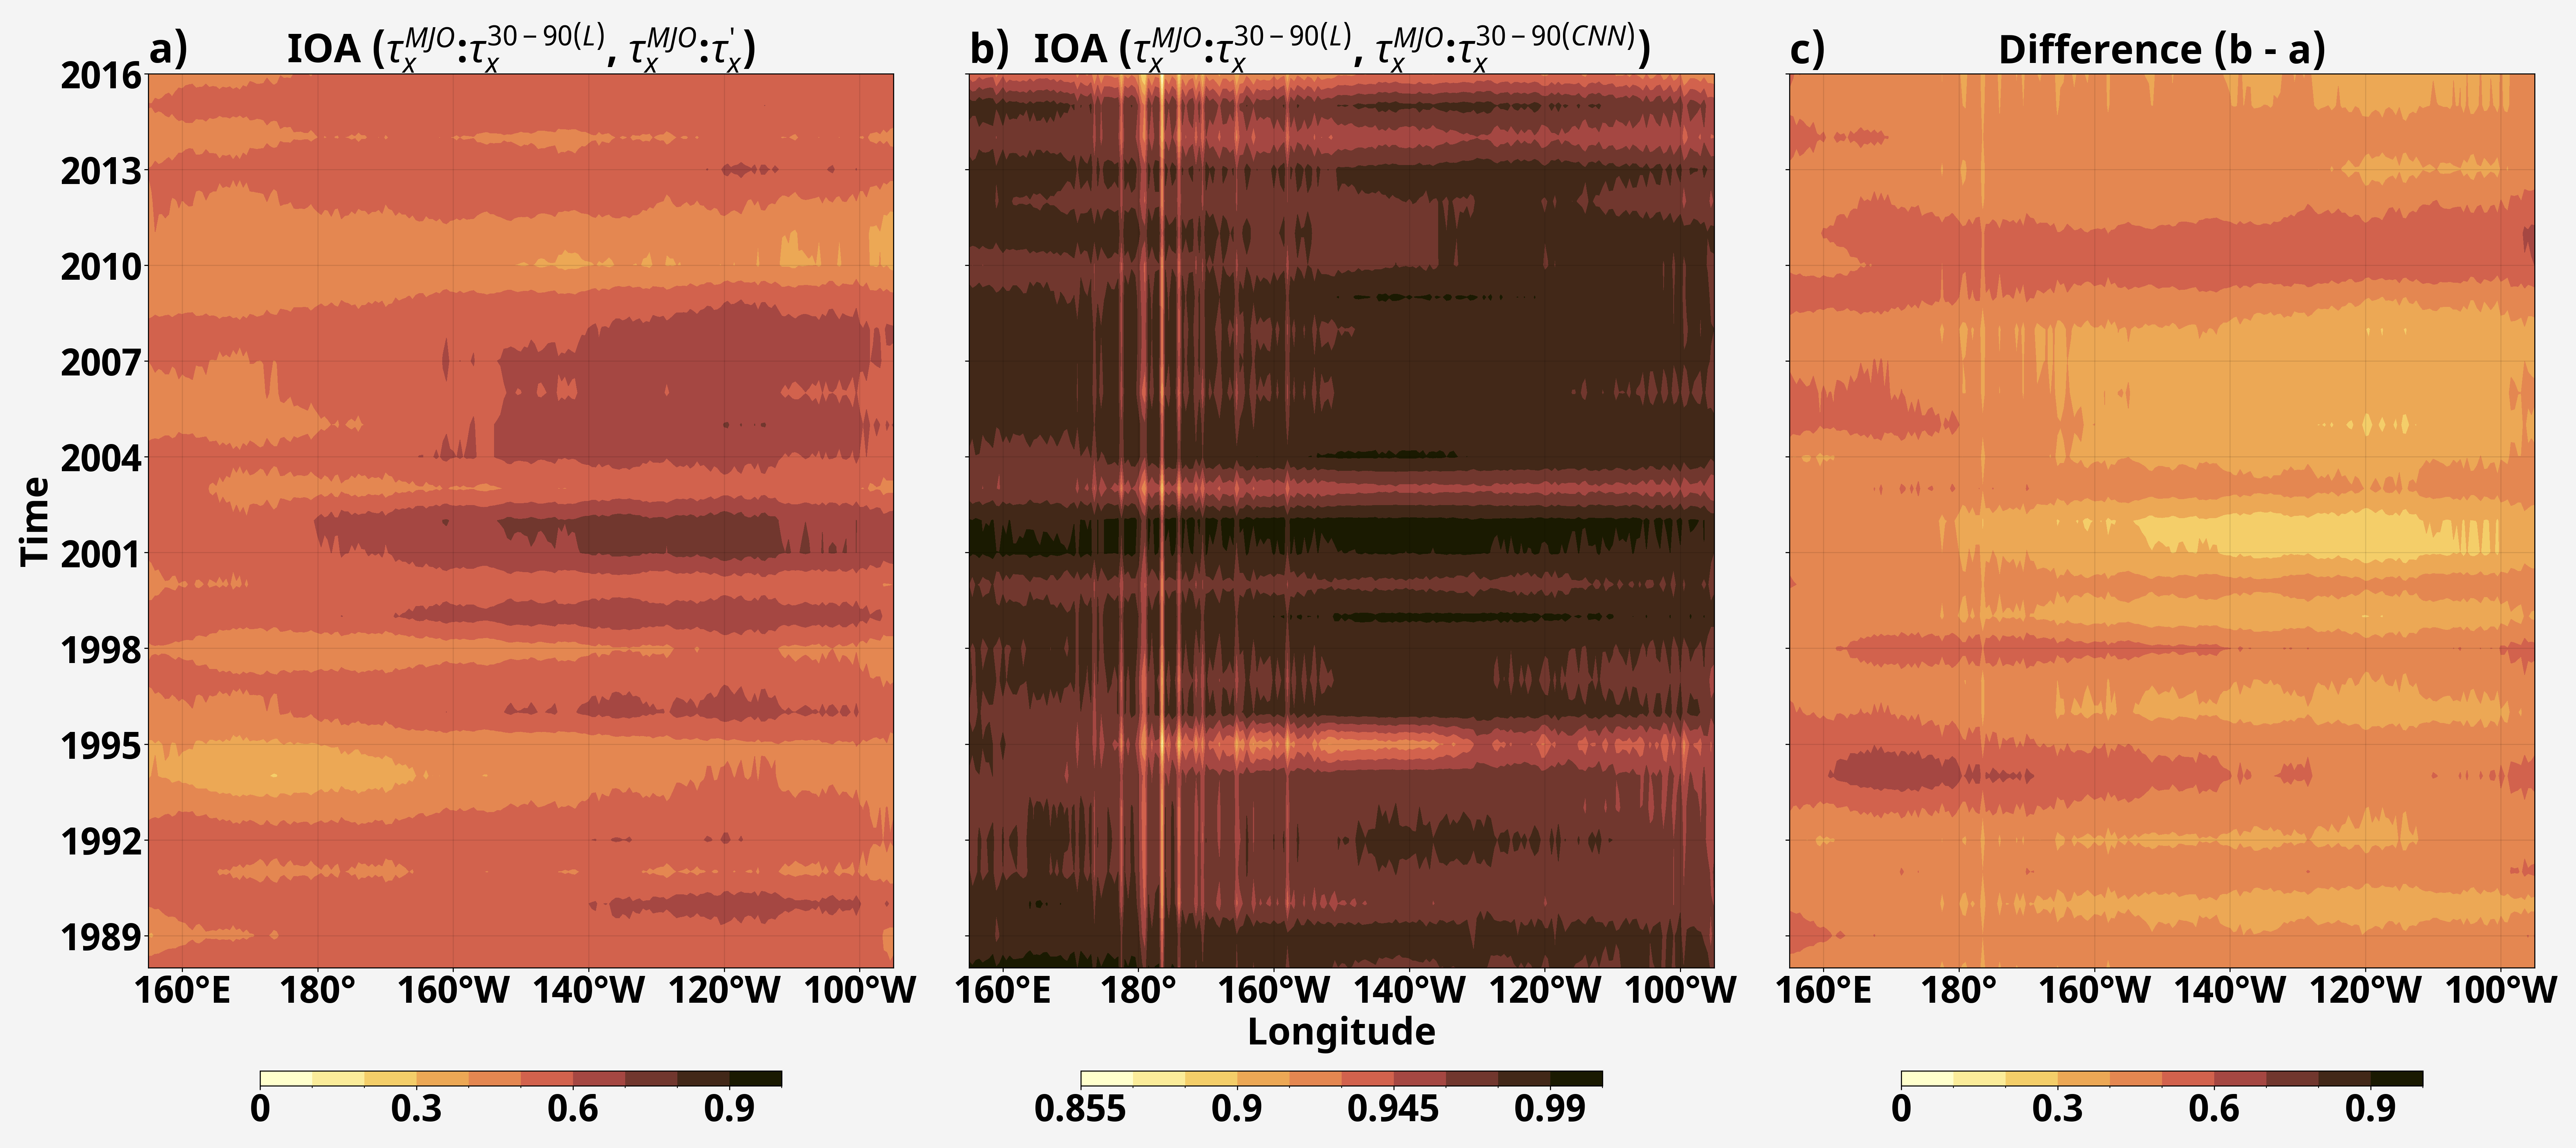

In [9]:
pplt.rc.update({'meta.width':1, 'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':36,'titlesize':38})

fig, axs = pplt.subplots(nrows=1,ncols=3,refwidth=10,refheight=12)#,refheight=22)

axs.format(xlabel='',ylabel='',xformatter='deglon',ylocator=3,xlocator=20,xtickminor=False,ytickminor=False,abc='a)',abcloc='l')

levels1 = np.arange(0,1.1,.1)
levels2 = np.arange(.9,1.01,.01)

im1 = axs[0].contourf(ioa_anom,cmap='lajolla',levels=levels1,extend='neither',colorbar=False)
im2 = axs[1].contourf(ioa_cnn,cmap='lajolla',vmin=ioa_cnn.min().values,extend='neither',colorbar=False)
axs[2].contourf((ioa_cnn - ioa_anom),cmap='lajolla',levels=levels1,extend='neither',colorbar=False)

#axs[0].set_title("IOA between " +r"$\tau_x^{MJO}$ reconstructed using $\tau_x^{30-90(L)}$[$\tau_x^{MJO}$:$\tau_x^{30-90(L)}]$"+"\n"+"and"+"\n"+r"$\tau_x^{MJO}$ reconstructed using $\tau_x'$[$\tau_x^{MJO}$:$\tau_x'$]")
#axs[1].set_title("Difference between "+r"IOA[$\tau_x^{MJO}$:$\tau_x^{30-90(L)}$, $\tau_x^{MJO}$:$\tau_x^{30-90(CNN)}$]"+"\n"+"and"+"\n"+r"IOA[$\tau_x^{MJO}$:$\tau_x^{30-90(L)}$, $\tau_x^{MJO}$:$\tau_x'$]")
axs[0].set_title(r"IOA ($\tau_x^{MJO}$:$\tau_x^{30-90(L)}$, $\tau_x^{MJO}$:$\tau_x'$)")
axs[1].set_title(r"IOA ($\tau_x^{MJO}$:$\tau_x^{30-90(L)}$, $\tau_x^{MJO}$:$\tau_x^{30-90(CNN)}$)")

axs[2].set_title('Difference (b - a)')
axs[0].colorbar(im1,location='bottom',shrink= 0.7, width= 0.2,label='')
axs[1].colorbar(im2,location='bottom',shrink= 0.7, width= 0.2,label='')
axs[2].colorbar(im1,location='bottom',shrink= 0.7, width= 0.2,label='')
axs.format(xlabel='Longitude',ylabel='Time')


fig.savefig('Fig8.png',dpi=150)